# 네이버 영화 리뷰 감성분석 

활용한 데이터 셋은 네이버 영화의 댓글을 모아 구성된 Naver sentiment movie corpus입니다. 

## 1. 데이터 준비와 확인


In [90]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

print(train_data.info(),"\n-----------------------------------\n",train_data.head() )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB
None 
-----------------------------------
          id                                           document  label
0   9976970                                아 더빙.. 진짜 짜증나네요 목소리      0
1   3819312                  흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나      1
2  10265843                                  너무재밓었다그래서보는것을추천한다      0
3   9045019                      교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정      0
4   6483659  사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...      1


train data는 0부터 149999 즉 150000개가 있습니다.            
데이터는 index, id, document,label로 이루어져있는것을 확인 할 수 있었습니다. 

In [91]:
train_data['document'].nunique(), train_data['label'].nunique()


(146182, 2)

중복된 데이터를 제외하면 146182개의 유니크한 데이터가 있음을 확인 할 수있었습니다.                 
label의 경우 긍정적인 1, 부정적인 0 두가지 categorical한 데이터이기 때문에 두 종류만 존재합니다. 

## 2. 데이터로더 구성


나만의 data_loader를 만들어 보는 것으로 시작합니다.           
data_loader에서 수행해야할 것들은 아래와 같습니다.

* 데이터의 중복 제거                                   
* NaN 결측치 제거         
* 한국어 토크나이저로 토큰화                     
* 불용어(Stopwords) 제거                 
* 사전word_to_index 구성                 
* 텍스트 스트링을 사전 인덱스 스트링으로 변환                    
* X_train, y_train, X_test, y_test, word_to_index 리턴                         

In [92]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True) # 중복값 제거 
    test_data.drop_duplicates(subset=['document'], inplace=True) # 중복값 제거 
    train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") #정규식으로 한글이 아닌것은 제거 
    test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규식 한글이 아닌것은 제거
    train_data['document'].replace('', np.nan, inplace=True) #공백값만 존재하면 nan로 변경
    test_data['document'].replace('', np.nan, inplace=True) # 공백값만 존재하면 nan로 변경
    train_data = train_data.dropna(how = 'any')  # na값 제거 
    test_data = test_data.dropna(how = 'any')  #na값 제거 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

load_data함수를 만든이후 함수를 통해
X_train, y_train,X_test, y_test, word_to_index를 원본 train_data,test_data에서 읽어왔습니다. 

In [93]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [94]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

그후 word_to_index를 이용하여 반대로 index_to_word를 만들었고,      
encode,decode 데이터 역시 만들 수 있었다. 

In [95]:
print(X_train[0])
print(X_train[:3])

print(len(X_train))
print(len(X_test))
print(len(X_train+X_test))



[27, 67, 895, 33, 214, 15, 28, 699]
[[27, 67, 895, 33, 214, 15, 28, 699], [977, 481, 491, 636, 4, 110, 1554, 48, 866, 949, 11, 38, 364], [19, 192, 2]]
145791
48995
194786


여러 전처리를 끝낸후 X_train은 145791, X_test는 48995가 되었음을 확인 할 수 있었다. 

## 3. 모델구성을 위한 데이터 분석 및 가공

* 데이터셋 내 문장 길이 분포
* 적절한 최대 문장 길이 지정
* keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가


In [96]:
total_data_text = X_train + X_test
# print(num_len[0])

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

In [97]:
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  13.75715400490795
문장길이 최대 :  83
문장길이 표준편차 :  11.462732932420181


In [98]:
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))


pad_sequences maxlen :  36
전체 문장의 0.9338145451931864%가 maxlen 설정값 이내에 포함됩니다. 


임베딩이란 단어 데이터를 저차원의 벡터로 표시하는 기법입니다.                
그렇기때문에 문장들의 길이를 일정하게 만들어야 임베딩이 가능합니다.              
그것을 위해 문장길이의 평균과 최대, 표준편차를 계산하여                 
mean+2표준편차인 36을 max값으로 잡습니다.               
게산한 결과 전체 문장의 약 93%정도가 36이내의 값을 가지고 있습니다.        

그리고 36보다 길이가 짧은 문장은 아래에서 \<PAD\> 을 추가합니다.

In [99]:

X_train[0]

[27, 67, 895, 33, 214, 15, 28, 699]

In [100]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)


In [101]:

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)



(145791, 36)


padding은 post, pre를 통해서 앞에 놓을지, 뒤에 놓을지 결정할 수 있습니다.             
RNN의 경우에는 먼저 입력된 데이터가 계속 뒤에 영향을 미침으로 패딩을 뒤에다 하는것이 좋다고 생각하였습니다. 

In [102]:
print(X_train[0])


[ 27  67 895  33 214  15  28 699   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


In [103]:
# threshold = 3
# total_cnt = len(tokenizer.word_index) # 단어의 수
# rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
# total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
# rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# # 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
# for key, value in tokenizer.word_counts.items():
#     total_freq = total_freq + value

#     # 단어의 등장 빈도수가 threshold보다 작으면
#     if(value < threshold):
#         rare_cnt = rare_cnt + 1
#         rare_freq = rare_freq + value

# print('단어 집합(vocabulary)의 크기 :',total_cnt)
# print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
# print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
# print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

## 4) validation set 구성




In [104]:
from sklearn.model_selection import train_test_split


partial_x_train, x_val, partial_y_train, y_val  = train_test_split(X_train,
                                                             y_train,
                                                            test_size = 0.2,
                                                            random_state = 5)

print('validation set :',len(x_val), 'validation set을 제외한 나머지:',len(partial_x_train))

validation set : 29159 validation set을 제외한 나머지: 116632


sklearn의 train_test_split을 통해서 train데이터에서 train데이터와 valdataion data를 분류하였습니다.

In [105]:
import pandas as pd

<AxesSubplot:xlabel='0'>

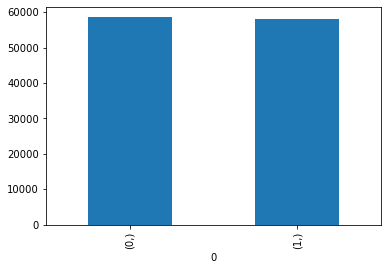

In [106]:
pd.DataFrame(partial_y_train).value_counts().plot(kind = 'bar')

<AxesSubplot:xlabel='0'>

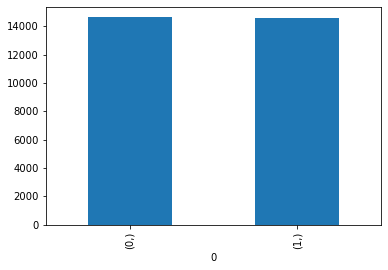

In [107]:
pd.DataFrame(y_val).value_counts().plot(kind = 'bar')

valdataion과 train data의 0(부정적인 리뷰),1(긍정적인 리뷰)의 빈도수가 비슷함을 확인 할 수 있었다. 

# 5) 모델 적합과 학습

## RNN 모델 

In [108]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16

model_RNN = keras.Sequential()
model_RNN.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_RNN.add(keras.layers.LSTM(10))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
model_RNN.add(keras.layers.Dense(8, activation='relu'))
model_RNN.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_RNN.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, None, 16)          160000    
_________________________________________________________________
lstm_7 (LSTM)                (None, 10)                1080      
_________________________________________________________________
dense_27 (Dense)             (None, 8)                 88        
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 9         
Total params: 161,177
Trainable params: 161,177
Non-trainable params: 0
_________________________________________________________________


In [109]:
model_RNN.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              




In [110]:
epochs=7  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_RNN = model_RNN.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/7
228/228 [==============================] - 2s 8ms/step - loss: 0.6067 - accuracy: 0.6350 - val_loss: 0.4148 - val_accuracy: 0.8247
Epoch 2/7
228/228 [==============================] - 1s 6ms/step - loss: 0.3638 - accuracy: 0.8438 - val_loss: 0.3634 - val_accuracy: 0.8393
Epoch 3/7
228/228 [==============================] - 2s 7ms/step - loss: 0.3269 - accuracy: 0.8601 - val_loss: 0.3624 - val_accuracy: 0.8412
Epoch 4/7
228/228 [==============================] - 2s 7ms/step - loss: 0.3106 - accuracy: 0.8672 - val_loss: 0.3648 - val_accuracy: 0.8388
Epoch 5/7
228/228 [==============================] - 1s 6ms/step - loss: 0.3015 - accuracy: 0.8697 - val_loss: 0.3653 - val_accuracy: 0.8406
Epoch 6/7
228/228 [==============================] - 1s 6ms/step - loss: 0.2917 - accuracy: 0.8739 - val_loss: 0.3813 - val_accuracy: 0.8379
Epoch 7/7
228/228 [==============================] - 2s 7ms/step - loss: 0.2831 - accuracy: 0.8756 - val_loss: 0.3826 - val_accuracy: 0.8375


In [111]:


results_RNN = model_RNN.evaluate(X_test,  y_test, verbose=2)

print(results_RNN)

1532/1532 - 3s - loss: 0.3879 - accuracy: 0.8346
[0.3879138231277466, 0.8345749378204346]


RNN모델은 test data에 대하여 약 83.5 퍼센트의 정확도를 보여주었습니다. 

## 1-D Convolution Neural Network(1-D CNN) 모델

In [112]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model_1D = keras.Sequential()
# [[YOUR CODE]]
model_1D.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape = (None,)))
model_1D.add(keras.layers.Conv1D(16,7,activation = 'relu'))
model_1D.add(keras.layers.MaxPooling1D(5))
model_1D.add(keras.layers.Conv1D(16,6,activation = 'relu'))
model_1D.add(keras.layers.GlobalMaxPooling1D())
model_1D.add(keras.layers.Dense(8,activation = 'relu'))
model_1D.add(keras.layers.Dense(1,activation = 'sigmoid'))

model_1D.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, None, 16)          160000    
_________________________________________________________________
conv1d_10 (Conv1D)           (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, None, 16)          1552      
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 16)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_30 (Dense)             (None, 1)               

In [113]:
model_1D.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              




In [114]:
epochs=7  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_1D = model_1D.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/7
228/228 [==============================] - 9s 39ms/step - loss: 0.5396 - accuracy: 0.7191 - val_loss: 0.3875 - val_accuracy: 0.8294
Epoch 2/7
228/228 [==============================] - 1s 6ms/step - loss: 0.3510 - accuracy: 0.8490 - val_loss: 0.3753 - val_accuracy: 0.8348
Epoch 3/7
228/228 [==============================] - 1s 5ms/step - loss: 0.3183 - accuracy: 0.8648 - val_loss: 0.3652 - val_accuracy: 0.8412
Epoch 4/7
228/228 [==============================] - 1s 5ms/step - loss: 0.2961 - accuracy: 0.8772 - val_loss: 0.3679 - val_accuracy: 0.8428
Epoch 5/7
228/228 [==============================] - 1s 5ms/step - loss: 0.2757 - accuracy: 0.8871 - val_loss: 0.3779 - val_accuracy: 0.8426
Epoch 6/7
228/228 [==============================] - 1s 5ms/step - loss: 0.2525 - accuracy: 0.8990 - val_loss: 0.3867 - val_accuracy: 0.8395
Epoch 7/7
228/228 [==============================] - 1s 6ms/step - loss: 0.2267 - accuracy: 0.9122 - val_loss: 0.4079 - val_accuracy: 0.8380


In [115]:


results_1D = model_1D.evaluate(X_test,  y_test, verbose=2)

print(results_1D)

1532/1532 - 2s - loss: 0.4051 - accuracy: 0.8380
[0.40514075756073, 0.8380038738250732]


1-D Convolution Neural Network(1-D CNN)도 약 83.4%로 비슷한 정확도를 보였습니다. 

## GlobalMaxPooling1D() 레이어 하나만 사용하는 방법

In [116]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

model_max = keras.Sequential()
model_max.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_max.add(keras.layers.GlobalMaxPooling1D())
model_max.add(keras.layers.Dense(8, activation='relu'))
model_max.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_max.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_9 (Glob (None, 16)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


이번에는 아예 MAXPooling 1D 한번만 사용하는 방법을 써보겠습니다. 

In [117]:


model_max.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=7  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model_max.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)


Epoch 1/7
228/228 [==============================] - 1s 4ms/step - loss: 0.5922 - accuracy: 0.7456 - val_loss: 0.4538 - val_accuracy: 0.8001
Epoch 2/7
228/228 [==============================] - 1s 5ms/step - loss: 0.3891 - accuracy: 0.8315 - val_loss: 0.3810 - val_accuracy: 0.8321
Epoch 3/7
228/228 [==============================] - 1s 4ms/step - loss: 0.3334 - accuracy: 0.8580 - val_loss: 0.3708 - val_accuracy: 0.8375
Epoch 4/7
228/228 [==============================] - 1s 5ms/step - loss: 0.3043 - accuracy: 0.8718 - val_loss: 0.3711 - val_accuracy: 0.8390
Epoch 5/7
228/228 [==============================] - 1s 5ms/step - loss: 0.2836 - accuracy: 0.8820 - val_loss: 0.3774 - val_accuracy: 0.8390
Epoch 6/7
228/228 [==============================] - 1s 5ms/step - loss: 0.2668 - accuracy: 0.8910 - val_loss: 0.3862 - val_accuracy: 0.8378
Epoch 7/7
228/228 [==============================] - 1s 5ms/step - loss: 0.2526 - accuracy: 0.8972 - val_loss: 0.3958 - val_accuracy: 0.8372


In [118]:


results_max = model_max.evaluate(X_test,  y_test, verbose=2)

print(results_max)

1532/1532 - 2s - loss: 0.3919 - accuracy: 0.8368
[0.39186400175094604, 0.836799681186676]


max_pooling만 사용한것은 약 83.7퍼센트의 정확도를 보였습니다.

## Lstm 128 모델

In [119]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [120]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16

model_longlstm = Sequential()
model_longlstm.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_longlstm.add(LSTM(128))
model_longlstm.add(Dense(1, activation='sigmoid'))



이번엔 RNN에서 LSTM부분을 128까지 늘려서 모델을 적합시켜보도록하겠습니다다. 

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

검증 데이터 손실(val_loss)이 증가하면, 과적합 징후므로 검증 데이터 손실이 4회 증가하면 학습을 조기 종료(Early Stopping)합니다.         
또한, ModelCheckpoint를 사용하여 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장합니다.

In [ ]:
또 이 모델에선 validataion_split을 미리한것을 쓰지않고 모델 내부에서 자체적으로 0.2로 분리한것을 사용하게 하였습니다. 

In [87]:
model_longlstm.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model_longlstm.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)


Epoch 1/15
1934/1944 [============================>.] - ETA: 0s - loss: 0.4302 - acc: 0.7983
Epoch 00001: val_acc improved from -inf to 0.83419, saving model to best_model.h5
1944/1944 [==============================] - 8s 4ms/step - loss: 0.4299 - acc: 0.7986 - val_loss: 0.3795 - val_acc: 0.8342
Epoch 2/15
1939/1944 [============================>.] - ETA: 0s - loss: 0.3605 - acc: 0.8435
Epoch 00002: val_acc improved from 0.83419 to 0.84012, saving model to best_model.h5
1944/1944 [==============================] - 9s 5ms/step - loss: 0.3604 - acc: 0.8436 - val_loss: 0.3730 - val_acc: 0.8401
Epoch 3/15
1937/1944 [============================>.] - ETA: 0s - loss: 0.3420 - acc: 0.8513
Epoch 00003: val_acc improved from 0.84012 to 0.84698, saving model to best_model.h5
1944/1944 [==============================] - 9s 5ms/step - loss: 0.3419 - acc: 0.8514 - val_loss: 0.3675 - val_acc: 0.8470
Epoch 4/15
1933/1944 [============================>.] - ETA: 0s - loss: 0.3248 - acc: 0.8604
Epoch 0

In [88]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1532/1532 [==============================] - 3s 2ms/step - loss: 0.3259 - acc: 0.8585

 테스트 정확도: 0.8585


가장 val_acc가 높았던 best_model.h5을 불러오자 85%의 정확도를 보이는것을 확인할 수 있었습니다. 


# 6) Loss, Accuracy 그래프 시각화
가장 높은 정확도를 보인 LSTM 128모델은 자체적으로 모델체크등을 하였기때문에 그다음으로 정확도가 높았던      
MAX_POOING을 사용한 모델의 LOSS와 ACCURACY 그래프 시각화를 해보겠습니다.


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


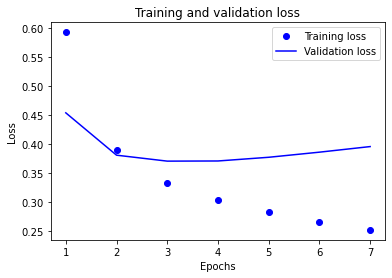

In [122]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


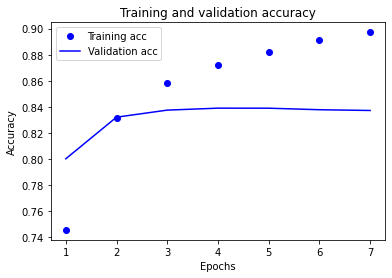

In [123]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


사실 2번만 진행해도 validation loss나 acc는 큰 변화가 없음을 확인 할 수 있다. 

# 7 학습된 Embedding 레이어 분석


In [128]:
embedding_layer = model_longlstm.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_naver.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()


(10000, 16)


In [129]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['스토리']
vector


array([-0.04139591, -0.01924681,  0.03025118,  0.02896437,  0.02653931,
       -0.03389286, -0.0206694 , -0.03940632, -0.04226606,  0.02541547,
       -0.00503282,  0.01525543,  0.02793336, -0.03578479,  0.0013651 ,
       -0.00198451], dtype=float32)

In [130]:
word_vectors.similar_by_word("납치")


[('카타르시스', 0.7815129160881042),
 ('근처', 0.772930920124054),
 ('스러울', 0.7532533407211304),
 ('쬐끔', 0.7519571185112),
 ('본방', 0.7321288585662842),
 ('분만', 0.7316253185272217),
 ('모자르', 0.7280247211456299),
 ('누드', 0.7269300818443298),
 ('깨어나', 0.721443772315979),
 ('싸구려', 0.7151851654052734)]

납치와 카타르시스, 근처가 가까운 단어로 분류됨을 확인할 수 있었다. 

# 8) 한국어 Word2Vec 임베딩 활용하여 성능개선


임베딩을 활용해 성능을 개선시켜보겠습니다. 

In [135]:
import gensim.models
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)



가져온 임베딩에서 강아지는 고양이, 거위, 토끼, 멧돼지, 엄마 등과 비슷하다고 평가되고 있었습니다.

In [136]:
result = word2vec.wv.most_similar("강아지")
print(result)

[('고양이', 0.7290453314781189), ('거위', 0.7185634970664978), ('토끼', 0.7056223750114441), ('멧돼지', 0.6950401067733765), ('엄마', 0.693433403968811), ('난쟁이', 0.6806551218032837), ('한마리', 0.6770296096801758), ('아가씨', 0.675035297870636), ('아빠', 0.6729634404182434), ('목걸이', 0.6512461304664612)]


In [137]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/home/ssac4/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/home/ssac4/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [138]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)



In [ ]:
아까 가장 성능이 좋았던 LSTM128 모델을 임베딩한 것을 통해서 학습시켜보도록하겠습니다. 

In [145]:
# 모델 구성
model = Sequential()
model.add(Embedding(vocab_size, word_vector_dim, embeddings_initializer=Constant(embedding_matrix),input_length=maxlen,trainable=True))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

model.summary()


Epoch 1/15
1941/1944 [============================>.] - ETA: 0s - loss: 0.4482 - acc: 0.7782
Epoch 00001: val_acc improved from -inf to 0.83940, saving model to best_model.h5
1944/1944 [==============================] - 23s 12ms/step - loss: 0.4481 - acc: 0.7782 - val_loss: 0.3581 - val_acc: 0.8394
Epoch 2/15
1940/1944 [============================>.] - ETA: 0s - loss: 0.3266 - acc: 0.8573
Epoch 00002: val_acc improved from 0.83940 to 0.85257, saving model to best_model.h5
1944/1944 [==============================] - 21s 11ms/step - loss: 0.3267 - acc: 0.8573 - val_loss: 0.3341 - val_acc: 0.8526
Epoch 3/15
1941/1944 [============================>.] - ETA: 0s - loss: 0.2890 - acc: 0.8764
Epoch 00003: val_acc improved from 0.85257 to 0.85963, saving model to best_model.h5
1944/1944 [==============================] - 21s 11ms/step - loss: 0.2890 - acc: 0.8764 - val_loss: 0.3266 - val_acc: 0.8596
Epoch 4/15
1940/1944 [============================>.] - ETA: 0s - loss: 0.2586 - acc: 0.8915
E

In [146]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1532/1532 [==============================] - 3s 2ms/step - loss: 0.3400 - acc: 0.8612

 테스트 정확도: 0.8612


약 86%의 정확도로 미세하지만 정확도 상승을 확인 할 수 있었습니다.         
또한 8번째 에포치에서 ealry stopping이 된것을 확인할 수 있었습니다.
아래는 그 시각화입니다.

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


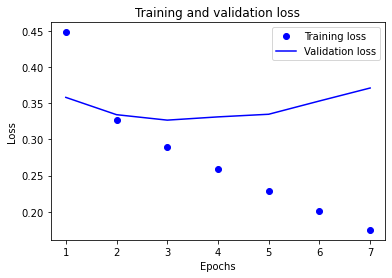

In [147]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들
import matplotlib.pyplot as plt

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


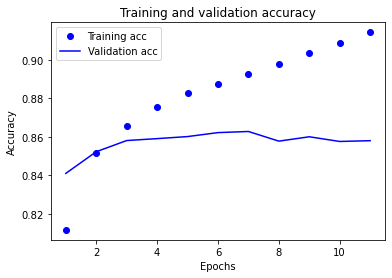

In [143]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [60]:
# model = keras.Sequential()
# model.add(keras.layers.Embedding(vocab_size, 
#                                  word_vector_dim, 
#                                  embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
#                                  input_length=maxlen, 
#                                  trainable=True))  
# model.add(keras.layers.GlobalMaxPooling1D())
# model.add(keras.layers.Dense(8, activation='relu'))
# model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

# model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 36, 200)           2000000   
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 200)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 1608      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 2,001,617
Trainable params: 2,001,617
Non-trainable params: 0
_________________________________________________________________


In [65]:
# # 학습의 진행
# model.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               metrics=['accuracy'])
              
# epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

# history = model.fit(partial_x_train,
#                     partial_y_train,
#                     epochs=epochs,
#                     batch_size=512,
#                     validation_data=(x_val, y_val),
#                     verbose=1)
# # 테스트셋을 통한 모델 평가
# results = model.evaluate(X_test,  y_test, verbose=2)

# print(results)


Epoch 1/10
200/200 [==============================] - 4s 22ms/step - loss: 0.4230 - accuracy: 0.8055 - val_loss: 0.4512 - val_accuracy: 0.7882
Epoch 2/10
200/200 [==============================] - 5s 24ms/step - loss: 0.4028 - accuracy: 0.8179 - val_loss: 0.4400 - val_accuracy: 0.7958
Epoch 3/10
200/200 [==============================] - 5s 24ms/step - loss: 0.3846 - accuracy: 0.8278 - val_loss: 0.4341 - val_accuracy: 0.8009
Epoch 4/10
200/200 [==============================] - 5s 24ms/step - loss: 0.3695 - accuracy: 0.8355 - val_loss: 0.4265 - val_accuracy: 0.8050
Epoch 5/10
200/200 [==============================] - 5s 23ms/step - loss: 0.3548 - accuracy: 0.8442 - val_loss: 0.4254 - val_accuracy: 0.8079
Epoch 6/10
200/200 [==============================] - 5s 23ms/step - loss: 0.3410 - accuracy: 0.8529 - val_loss: 0.4220 - val_accuracy: 0.8113
Epoch 7/10
200/200 [==============================] - 5s 23ms/step - loss: 0.3302 - accuracy: 0.8571 - val_loss: 0.4174 - val_accuracy: 0.8141

In [66]:
# results = model.evaluate(X_test,  y_test, verbose=2)

# print(results)


1532/1532 - 2s - loss: 0.4185 - accuracy: 0.8169
[0.41845569014549255, 0.8168588876724243]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


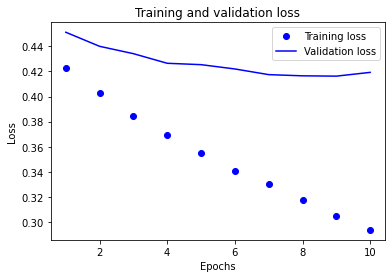

In [67]:
# history_dict = history.history
# print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들
# import matplotlib.pyplot as plt

# acc = history_dict['accuracy']
# val_acc = history_dict['val_accuracy']
# loss = history_dict['loss']
# val_loss = history_dict['val_loss']

# epochs = range(1, len(acc) + 1)

# # "bo"는 "파란색 점"입니다
# plt.plot(epochs, loss, 'bo', label='Training loss')
# # b는 "파란 실선"입니다
# plt.plot(epochs, val_loss, 'b', label='Validation loss')
# plt.title('Training and validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# plt.show()


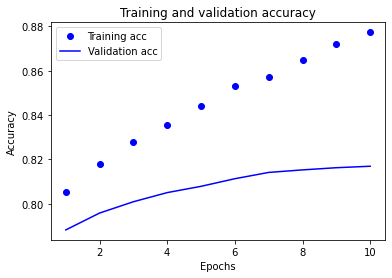

In [68]:
# plt.clf()   # 그림을 초기화합니다

# plt.plot(epochs, acc, 'bo', label='Training acc')
# plt.plot(epochs, val_acc, 'b', label='Validation acc')
# plt.title('Training and validation accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.show()


In [69]:
# from tensorflow.keras.layers import Embedding, Dense, LSTM
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.models import load_model
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [70]:
# model = Sequential()
# model.add(Embedding(vocab_size, 100))
# model.add(LSTM(128))
# model.add(Dense(1, activation='sigmoid'))



In [71]:
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
# mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [72]:
# model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
# history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)


Epoch 1/15
1943/1944 [============================>.] - ETA: 0s - loss: 0.4122 - acc: 0.8125
Epoch 00001: val_acc improved from -inf to 0.84139, saving model to best_model.h5
1944/1944 [==============================] - 12s 6ms/step - loss: 0.4122 - acc: 0.8125 - val_loss: 0.3835 - val_acc: 0.8414
Epoch 2/15
1937/1944 [============================>.] - ETA: 0s - loss: 0.3395 - acc: 0.8534
Epoch 00002: val_acc improved from 0.84139 to 0.85198, saving model to best_model.h5
1944/1944 [==============================] - 12s 6ms/step - loss: 0.3395 - acc: 0.8534 - val_loss: 0.3519 - val_acc: 0.8520
Epoch 3/15
1943/1944 [============================>.] - ETA: 0s - loss: 0.3139 - acc: 0.8652
Epoch 00003: val_acc improved from 0.85198 to 0.85788, saving model to best_model.h5
1944/1944 [==============================] - 12s 6ms/step - loss: 0.3139 - acc: 0.8652 - val_loss: 0.3311 - val_acc: 0.8579
Epoch 4/15
1937/1944 [============================>.] - ETA: 0s - loss: 0.2965 - acc: 0.8751
Epoc

In [73]:
# loaded_model = load_model('best_model.h5')
# print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1532/1532 [==============================] - 3s 2ms/step - loss: 0.3234 - acc: 0.8608

 테스트 정확도: 0.8608


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


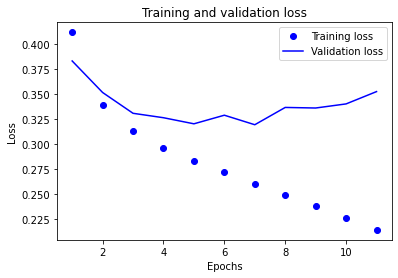

In [76]:
# # history_dict = history.history
# print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들
# import matplotlib.pyplot as plt

# acc = history_dict['acc']
# val_acc = history_dict['val_acc']
# loss = history_dict['loss']
# val_loss = history_dict['val_loss']

# epochs = range(1, len(acc) + 1)

# # "bo"는 "파란색 점"입니다
# plt.plot(epochs, loss, 'bo', label='Training loss')
# # b는 "파란 실선"입니다
# plt.plot(epochs, val_loss, 'b', label='Validation loss')
# plt.title('Training and validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# plt.show()


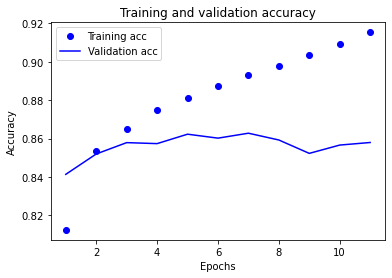

In [77]:
# plt.clf()   # 그림을 초기화합니다

# plt.plot(epochs, acc, 'bo', label='Training acc')
# plt.plot(epochs, val_acc, 'b', label='Validation acc')
# plt.title('Training and validation accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.show()
